In [5]:
import matplotlib.pyplot as plt
import sys
from os.path import dirname
sys.path.append(dirname('./synthcity/src/'))
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.optim as optim
from torch.utils.data import DataLoader
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks
from synthcity.utils.datasets.time_series.pbc import PBCDataloader
from synthcity.plugins.core.dataloader import TimeSeriesDataLoader
from synthcity.plugins.core.dataloader import TimeSeriesSurvivalDataLoader
from sklearn.preprocessing import MinMaxScaler
from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig
from gretel_synthetics.timeseries_dgan.config import DfStyle

In [6]:
from metrics import compute_predictive_score, compute_discriminative_score

In [7]:
# from discriminative_metrics import discriminative_score_metrics
# from predictive_metrics import predictive_score_metrics

In [8]:
from gretel_synthetics.timeseries_dgan.config import OutputType

In [9]:
(static_data, temporal_data,observation_times, outcome) = PBCDataloader().load()

In [10]:
cleaned_observation_times = []
cleaned_temporal_data = []
cleaned_static_data = []
first_outcome = []
second_outcome = []
keep_index = []
drop_index = []


In [11]:
min_len = 10

In [12]:
for i in range(len(observation_times)):
    if len(observation_times[i]) >= min_len:
        cleaned_observation_times.append(observation_times[i][:min_len])
        cleaned_temporal_data.append(temporal_data[i].iloc[:min_len])
        first_outcome.append(outcome[0][i])
        second_outcome.append(outcome[1][i])
        keep_index.append(i)
    else:
        drop_index.append(i)

In [13]:
index = []

In [14]:
for i in range(len(keep_index)):
    index.append(i)

In [15]:
outcome = (pd.Series(first_outcome, index = index), pd.Series(second_outcome, index = index))

In [16]:
T, E = outcome

In [17]:
horizons = [0.25, 0.5, 0.75]
time_horizons = np.quantile(T, horizons).tolist()

In [18]:
static_data.drop(index=drop_index, inplace=True)

In [19]:
static_data.reset_index(inplace=True)

In [20]:
data = TimeSeriesSurvivalDataLoader(
    temporal_data=cleaned_temporal_data,
    observation_times=cleaned_observation_times,
    static_data=static_data,
    T = T,
    E = E,
    time_horizons = time_horizons,
)

Unique Temporal Data
finding max len
Checking Outcome
Pack raw data
Running initializer


In [21]:
discrete_cols = ["seq_static_sex", "seq_temporal_ascites", "seq_temporal_drug", "seq_temporal_edema", "seq_temporal_hepatomegaly", "seq_temporal_histologic", "seq_temporal_spiders", "seq_out_event"]

In [22]:
df = data.dataframe()

In [23]:
for col in discrete_cols:
    df[col] = df[col].astype('int')

In [24]:
df = df.drop('seq_static_index', axis = 1)

In [25]:
df

,seq_id,seq_time_id,seq_static_sex,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_ascites,seq_temporal_drug,seq_temporal_edema,seq_temporal_hepatomegaly,seq_temporal_histologic,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_temporal_spiders,seq_out_time_to_event,seq_out_event
0,0,0.186179,0,-0.021301,0.652178,-2.147295,-0.613492,1,1,1,1,3,-1.061531,2.774588,1.103602,0.000000,1,0.186179,1
1,0,1.314204,0,-0.212585,0.652178,-1.570646,-0.744363,1,1,1,1,3,-1.479124,1.421860,0.005150,-0.990457,1,0.186179,1
2,0,2.105465,0,-0.199833,0.652178,-1.550762,-0.712920,0,1,1,0,3,-1.635721,1.218951,0.172710,-0.666808,1,0.186179,1
3,0,3.151353,0,-0.301851,0.652178,-1.113304,-0.791953,0,1,2,0,3,-1.552202,0.542587,-0.013468,-0.887836,1,0.186179,1
4,0,4.271164,0,-0.299301,0.652178,-0.019660,-0.678078,0,1,0,1,3,-1.312087,0.542587,-0.087939,0.000000,1,0.186179,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,70,4.881722,0,-1.079741,-1.453935,0.676296,-0.740114,0,0,0,0,0,1.412704,-0.336687,-0.609239,-0.603657,0,7.772971,0
706,70,5.878327,0,-1.156254,-1.453935,-0.019660,-0.710371,0,0,0,0,0,1.757218,-0.742505,-0.590621,-0.461567,0,7.772971,0
707,70,6.894097,0,-1.069539,-1.453935,0.139416,-0.735865,0,0,0,0,0,1.276986,-0.877778,-0.590621,-0.635232,0,7.772971,0
708,70,7.288358,0,-0.792814,-1.453935,0.238838,-0.434181,0,0,0,0,0,2.080852,-0.607232,-0.572003,0.000000,0,7.772971,0


In [26]:
# test_df["seq_id"] = test_df["seq_id"] + 51

In [27]:
model = DGAN(DGANConfig(
    max_sequence_len=min_len,
    sample_len=min_len,
    batch_size=32,
    apply_feature_scaling=True,
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=1000,
))

In [28]:
atrribute_columns = ["seq_out_time_to_event", "seq_out_event", "seq_static_sex", "seq_temporal_age"]
feature_columns = ["seq_temporal_SGOT", "seq_temporal_albumin", "seq_temporal_alkaline", "seq_temporal_ascites", "seq_temporal_drug", "seq_temporal_edema", "seq_temporal_hepatomegaly", "seq_temporal_histologic", "seq_temporal_platelets", "seq_temporal_prothrombin", "seq_temporal_serBilir", "seq_temporal_serChol", "seq_temporal_spiders"]

In [29]:
model.train_dataframe(
    df,
    attribute_columns=atrribute_columns,
    feature_columns=feature_columns,
    time_column = "seq_time_id",
    example_id_column = "seq_id",
    discrete_columns = discrete_cols,
    df_style = DfStyle.LONG
)

In [30]:
synthetic_df_dopple = model.generate_dataframe(len(df)//min_len)

In [31]:
synthetic_df_dopple

,seq_id,seq_time_id,seq_static_sex,seq_temporal_SGOT,seq_temporal_age,seq_temporal_albumin,seq_temporal_alkaline,seq_temporal_ascites,seq_temporal_drug,seq_temporal_edema,seq_temporal_hepatomegaly,seq_temporal_histologic,seq_temporal_platelets,seq_temporal_prothrombin,seq_temporal_serBilir,seq_temporal_serChol,seq_temporal_spiders,seq_out_time_to_event,seq_out_event
0,0,0.186179,0,-0.132725,0.219874,-2.296350,-0.256993,0,1,1,2,3,-1.151186,1.414830,1.063042,-0.331213,2,14.291375,0
1,0,1.314204,0,0.055340,0.219874,-1.738565,-0.448233,0,1,1,1,3,-1.075804,0.824897,0.104555,-0.668541,1,14.291375,0
2,0,2.105465,0,-0.248103,0.219874,-1.655480,-0.401954,0,1,0,1,3,-0.959852,0.135664,-0.082250,-0.747982,0,14.291375,0
3,0,3.151353,0,-0.479384,0.219874,-1.284914,-0.621536,0,1,0,1,3,-1.178180,-0.018534,-0.109829,-0.619463,0,14.291375,0
4,0,4.271164,0,-0.584363,0.219874,-1.443712,-0.357420,0,1,0,1,3,-1.067801,0.036465,-0.212887,-0.370266,0,14.291375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,70,5.306100,0,-0.146232,0.564383,0.229390,-0.336124,0,0,0,0,3,-0.101537,-0.035934,-0.092521,0.564736,0,0.003471,1
706,70,6.245209,0,-0.286081,0.564383,0.995720,-0.355852,0,0,0,0,3,0.348252,-0.120077,-0.234053,-0.339332,0,0.003471,1
707,70,7.255503,0,0.164243,0.564383,1.965806,-0.435062,0,0,0,0,3,-0.056873,-0.213081,-0.059672,-0.259748,0,0.003471,1
708,70,8.257584,0,-0.215441,0.564383,0.829732,0.061546,0,0,0,1,3,-0.338682,-0.428816,-0.199719,0.925143,0,0.003471,1


In [32]:
generated_data = synthetic_df_dopple.to_numpy()
ori_data = df.to_numpy()

In [44]:
seq_len = min_len
ori_data_cleaned = []
generated_data_cleaned = []

In [45]:
for i in range(0, len(ori_data), seq_len):
    ori_data_cleaned.append(ori_data[i:i+seq_len])
for i in range(0, len(generated_data), seq_len):
    generated_data_cleaned.append(generated_data[i:i+seq_len])

In [48]:
ori_data_cleaned = torch.tensor(ori_data_cleaned)
generated_data_cleaned = torch.tensor(generated_data_cleaned)

In [49]:
iterations = 100
disc_scores = []
pred_scores = []
for i in range(iterations):
    disc_scores.append(compute_discriminative_score(ori_data_cleaned, generated_data_cleaned))
    pred_scores.append(compute_predictive_score(ori_data_cleaned, generated_data_cleaned))

In [50]:
print(np.mean(disc_scores))
print(np.mean(pred_scores))

0.7428591549396515
77.62903812408447


In [28]:
def create_sequence(dataset, seq_len):
    sequences = []
    labels = []
    for index in range(0, len(dataset)//seq_len): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[index*seq_len:(index+1)*seq_len, dataset.columns != 'seq_out_event'])
        labels.append(dataset.iloc[(index+1)*seq_len-1][-1])
    return (np.array(sequences),np.array(labels))

In [29]:
def gen_labels(data):
    sequences = []
    labels = []
    for index in data: # Selecting 50 rows at a time
        cur = []
        for itm in index:
            cur.append(itm[:-1])
        labels.append(index[0][-1])
        sequences.append(cur)
    return (np.asarray(sequences),np.asarray(labels))

In [30]:
def create_sequence_for_split(dataset, seq_len):
    sequences = []
    labels = []
    for index in range(0, len(dataset)//seq_len): # Selecting 50 rows at a time
        sequences.append(dataset.iloc[index*seq_len:(index+1)*seq_len])
    return np.array(sequences)

In [31]:
class Network(nn.Module):
    def __init__(self, dropout,
                 input_dim=18, num_classes = 1, num_layers = 2, hidden_size = 64, **kwargs):

        super(Network, self).__init__()

        print("==> not used params in network class:", kwargs.keys())

        self.input_dim = input_dim
        self.dropout = dropout
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        # Main part of the network
        # self.lstm_layers = nn.ModuleList()
        # self.lstm_layers.append(nn.LSTM(input_size=input_dim,hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # self.lstm_layers.append(nn.LSTM(input_size=self.hidden_size,
        #                    hidden_size=self.hidden_size))
        # self.lstm_layers.append(nn.Dropout(p=dropout))
        # Output layer
        # self.output_layer = nn.Linear(self.hidden_size, num_classes)
        #self.output_activation = nn.Sigmoid()

    def forward(self, X, lengths=None):
        # Input layer
        X = X.to(torch.float32)
        mX = X
        # # Main part of the network
        # i = 0
        # for lstm in self.lstm_layers:
        #     if i % 2 == 0:
        #         output, _ = lstm(mX)
        #     else:
        #         output = lstm(mX)
        #     mX = output
        #     i += 1
        # L = output[:, -1, :]
        # # Output layer
        # y = self.output_layer(L)
        h0 = torch.zeros(self.num_layers, mX.size(0), self.hidden_size).to(mX.device)
        c0 = torch.zeros(self.num_layers, mX.size(0), self.hidden_size).to(mX.device)
        
        out, _ = self.lstm(mX, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out


In [32]:
def run_model(model, training_error, testing_error, X_train, y_train, X_test, y_test, learning_rate = 0.001):
    loss = nn.BCEWithLogitsLoss()
    train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=1)
    val_loader = DataLoader(list(zip(X_test, y_test)), batch_size=1, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(0, 100):
        model.train()
        step_loss = []
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = batch
            outputs = model(inputs)
            targets = targets.reshape(tuple(outputs.shape))
            targets = targets.to(torch.float32)
            batch_loss = loss(outputs, targets)
            batch_loss.backward()
            optimizer.step()
            step_loss.append(batch_loss.item())
        training_error.append(np.array(step_loss).mean())
        model.eval()
        val_loss = 0
        with torch.no_grad():
            num_batches = 0
            res = {}
            y_true = []
            predictions = []
            for batch in val_loader:
                inputs, targets = batch
                outputs = model(inputs)
                targets = targets.reshape(tuple(outputs.shape))
                targets = targets.to(torch.float32)
                batch_loss = loss(outputs, targets)
                val_loss += batch_loss.item()
                num_batches += 1
            val_loss /= num_batches
            print('Epoch [{}/{}], Step [{}/{}], Validation Batch Loss: {:.4f}'
                    .format(epoch + 1, 100, i + 1, len(train_loader), val_loss))
        testing_error.append(val_loss)

In [33]:
seq = create_sequence_for_split(df, min_len)

In [34]:
train_data, test_data = train_test_split(seq, test_size=0.2)

In [35]:
X_train, y_train = gen_labels(train_data)

In [36]:
X_test, y_test = gen_labels(test_data)

In [37]:
synth_dopple_X, synth_dopple_Y = create_sequence(synthetic_df_dopple, min_len)

In [38]:
generated_data = synthetic_df_dopple.to_numpy()
ori_data = df.to_numpy()

In [39]:
disc_score = discriminative_score_metrics(ori_data, generated_data)
pred_score = predictive_score_metrics(ori_data, generated_data)

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [449]:
regular_model = Network(0.2)
trainingEpoch_loss = []
validationEpoch_loss = []
run_model(regular_model, trainingEpoch_loss, validationEpoch_loss, X_train, y_train, X_test, y_test, learning_rate= 0.001)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [56/56], Validation Batch Loss: 0.1222
Epoch [2/100], Step [56/56], Validation Batch Loss: 0.0111
Epoch [3/100], Step [56/56], Validation Batch Loss: 0.0049
Epoch [4/100], Step [56/56], Validation Batch Loss: 0.0031
Epoch [5/100], Step [56/56], Validation Batch Loss: 0.0022
Epoch [6/100], Step [56/56], Validation Batch Loss: 0.0016
Epoch [7/100], Step [56/56], Validation Batch Loss: 0.0012
Epoch [8/100], Step [56/56], Validation Batch Loss: 0.0010
Epoch [9/100], Step [56/56], Validation Batch Loss: 0.0008
Epoch [10/100], Step [56/56], Validation Batch Loss: 0.0007
Epoch [11/100], Step [56/56], Validation Batch Loss: 0.0006
Epoch [12/100], Step [56/56], Validation Batch Loss: 0.0005
Epoch [13/100], Step [56/56], Validation Batch Loss: 0.0005
Epoch [14/100], Step [56/56], Validation Batch Loss: 0.0004
Epoch [15/100], Step [56/56], Validation Batch Loss: 0.0004
Epoch [16/100], Step [56/56], Validation Batch Loss: 0.00

In [448]:
dopple_model = Network(0.2)
trainingEpoch_dopple_loss = []
validationEpoch_dopple_loss = []
run_model(dopple_model, trainingEpoch_dopple_loss, validationEpoch_dopple_loss, synth_dopple_X, synth_dopple_Y, X_test, y_test, learning_rate= 0.001)

==> not used params in network class: dict_keys([])
Epoch [1/100], Step [71/71], Validation Batch Loss: 1.2609
Epoch [2/100], Step [71/71], Validation Batch Loss: 0.2443
Epoch [3/100], Step [71/71], Validation Batch Loss: 0.1902
Epoch [4/100], Step [71/71], Validation Batch Loss: 0.1737
Epoch [5/100], Step [71/71], Validation Batch Loss: 0.2006
Epoch [6/100], Step [71/71], Validation Batch Loss: 0.1890
Epoch [7/100], Step [71/71], Validation Batch Loss: 0.1056
Epoch [8/100], Step [71/71], Validation Batch Loss: 0.3844
Epoch [9/100], Step [71/71], Validation Batch Loss: 0.1266
Epoch [10/100], Step [71/71], Validation Batch Loss: 0.1826
Epoch [11/100], Step [71/71], Validation Batch Loss: 0.1053
Epoch [12/100], Step [71/71], Validation Batch Loss: 0.1993
Epoch [13/100], Step [71/71], Validation Batch Loss: 0.2039
Epoch [14/100], Step [71/71], Validation Batch Loss: 0.3711
Epoch [15/100], Step [71/71], Validation Batch Loss: 0.2519
Epoch [16/100], Step [71/71], Validation Batch Loss: 0.06

<function matplotlib.pyplot.show(close=None, block=None)>

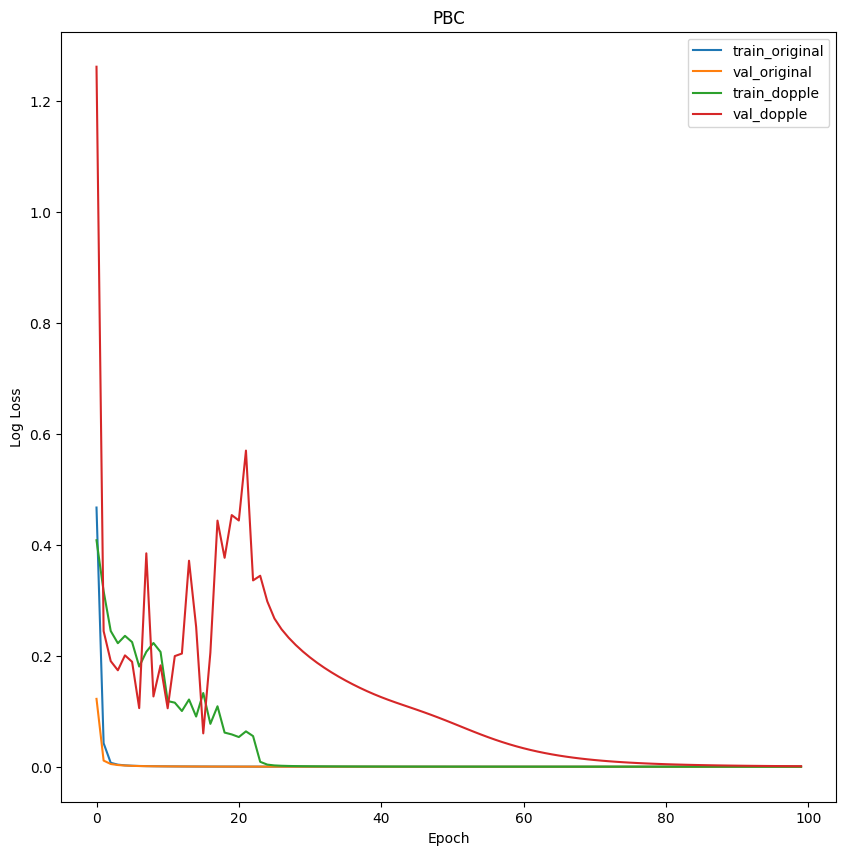

In [450]:
plt.figure(figsize=(10,10))
plt.title("PBC")
plt.plot(trainingEpoch_loss, label='train_original')
plt.plot(validationEpoch_loss,label='val_original')
# plt.plot(trainingEpoch_no_dp_loss, label='train_no_dp_synthetic')
# plt.plot(validationEpoch_no_dp_loss,label='val_no_dp_synthetic')
# plt.plot(trainingEpoch_dp_loss, label='train_dp_eps=1_synthetic')
# plt.plot(validationEpoch_dp_loss,label='val_dp_eps=1_synthetic')
# plt.plot(trainingEpoch_dp_eps5_loss, label='train_dp_eps=5_synthetic')
# plt.plot(validationEpoch_dp_eps5_loss,label='val_dp_eps=5_synthetic')
# plt.plot(trainingEpoch_dp_eps20_loss, label='train_dp_eps=20_synthetic')
# plt.plot(validationEpoch_dp_eps20_loss,label='val_dp_eps=20_synthetic')
plt.plot(trainingEpoch_dopple_loss, label='train_dopple')
plt.plot(validationEpoch_dopple_loss,label='val_dopple')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.show